<a href="https://colab.research.google.com/github/larislima11/Dashboard_DataMine_Use_Car_Dataset/blob/main/Dashboard_DataMine_Use_Car_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-10-1482addf8dd3>:13: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

<ipython-input-10-1482addf8dd3>:16: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-10-1482addf8dd3>:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method w

           Brand      model  Year  Age     kmDriven Transmission   Owner  \
0          Honda       City  2001   23    98,000 km       Manual  second   
1         Toyota     Innova  2009   15  190000.0 km       Manual  second   
2     Volkswagen  VentoTest  2010   14    77,246 km       Manual   first   
3  Maruti Suzuki      Swift  2017    7    83,500 km       Manual  second   
4  Maruti Suzuki     Baleno  2019    5    45,000 km    Automatic   first   

  FuelType PostedDate                                       AdditionInfo  \
0   Petrol     Nov-24  Honda City v teck in mint condition, valid gen...   
1   Diesel     Jul-24  Toyota Innova 2.5 G (Diesel) 7 Seater, 2009, D...   
2   Diesel     Nov-24  Volkswagen Vento 2010-2013 Diesel Breeze, 2010...   
3   Diesel     Nov-24     Maruti Suzuki Swift 2017 Diesel Good Condition   
4   Petrol     Nov-24       Maruti Suzuki Baleno Alpha CVT, 2019, Petrol   

     AskPrice  Quilometragem  PrecoPedido DataPostagem  PrecoPorKm  
0  ₹ 1,95,000    

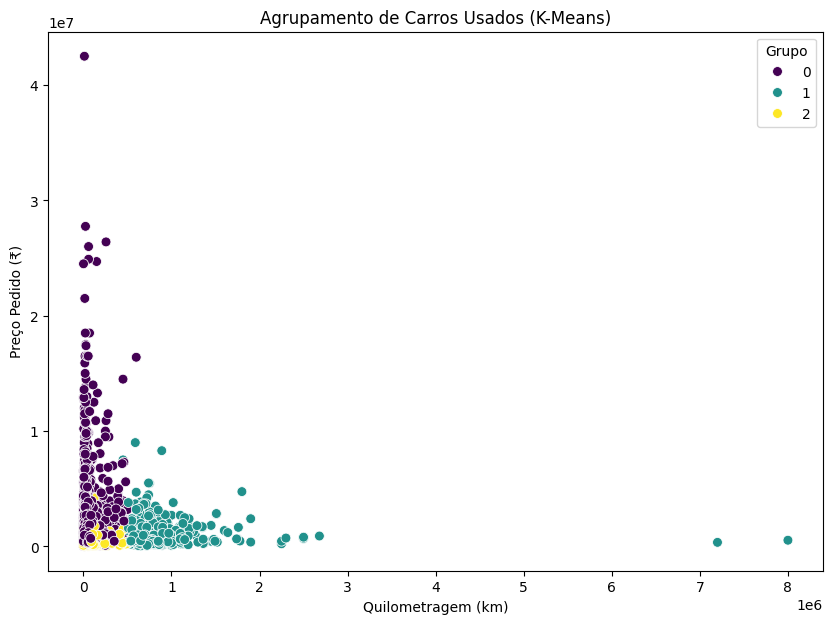

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np

# Caminho para o arquivo de dados
arquivo_dados = 'used_car_dataset.csv'

# Carregando os dados
dados = pd.read_csv(arquivo_dados)

# Renomeando e limpando colunas relevantes
dados['Quilometragem'] = dados['kmDriven'].str.replace(r'\D', '', regex=True).astype(float)
dados['PrecoPedido'] = dados['AskPrice'].str.replace(r'\D', '', regex=True).astype(float)
dados['DataPostagem'] = pd.to_datetime(dados['PostedDate'], errors='coerce')

# Preenchendo valores ausentes nas colunas relevantes
dados['Quilometragem'].fillna(dados['Quilometragem'].median(), inplace=True)
dados['PrecoPedido'].fillna(dados['PrecoPedido'].median(), inplace=True)

# Criando uma nova coluna para Preço por Km
dados['PrecoPorKm'] = dados['PrecoPedido'] / dados['Quilometragem']

# Substituindo valores infinitos resultantes da divisão
dados['PrecoPorKm'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Preenchendo valores ausentes restantes
dados.fillna(dados.median(numeric_only=True), inplace=True)

# Removendo duplicatas
dados.drop_duplicates(inplace=True)

# Salvando os dados limpos em um novo arquivo
dados.to_csv('dados_carros_limpos.csv', index=False)
print(dados.head())

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Carregando os dados limpos
arquivo_dados_limpos = 'dados_carros_limpos.csv'
dados = pd.read_csv(arquivo_dados_limpos)

# Selecionando as colunas para clusterização
features = ['Year', 'Quilometragem', 'PrecoPedido', 'PrecoPorKm']

# Normalizando os dados
escalador = StandardScaler()
dados_escalados = escalador.fit_transform(dados[features])

# Aplicando o algoritmo K-Means
modelo_kmeans = KMeans(n_clusters=3, random_state=42)
clusters = modelo_kmeans.fit_predict(dados_escalados)

# Adicionando os clusters ao DataFrame
dados['Grupo'] = clusters

# Visualizando os clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(data=dados, x='Quilometragem', y='PrecoPedido', hue='Grupo', palette='viridis', s=50)
plt.title('Agrupamento de Carros Usados (K-Means)')
plt.xlabel('Quilometragem (km)')
plt.ylabel('Preço Pedido (₹)')
plt.legend(title='Grupo')
plt.show()

from dash import dcc, html, Input, Output
import dash
import dash_bootstrap_components as dbc
import plotly.express as px

# Carregando os dados limpos
dados = pd.read_csv('dados_carros_limpos.csv')

# Inicializando o aplicativo Dash
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Layout do Dashboard
app.layout = dbc.Container([
    dbc.Row([
        dbc.Col(html.H1("Análise de Carros Usados", className="text-center text-primary mb-4"), width=12)
    ]),
    dbc.Row([
        dbc.Col([
            html.Label("Selecione a Marca:"),
            dcc.Dropdown(
                id='filtro-marca',
                options=[{'label': marca, 'value': marca} for marca in sorted(dados['Brand'].unique())],
                multi=True,
                placeholder="Filtrar por marca"
            )
        ], width=4),
        dbc.Col([
            html.Label("Ano de Fabricação:"),
            dcc.RangeSlider(
                id='filtro-ano',
                min=dados['Year'].min(),
                max=dados['Year'].max(),
                marks={ano: str(ano) for ano in range(dados['Year'].min(), dados['Year'].max() + 1, 2)},
                step=1,
                value=[dados['Year'].min(), dados['Year'].max()]
            )
        ], width=8),
    ], className="mb-4"),
    dbc.Row([
        dbc.Col(dcc.Graph(id='grafico-precos'), width=6),
        dbc.Col(dcc.Graph(id='grafico-km'), width=6)
    ]),
    dbc.Row([
        dbc.Col(dcc.Graph(id='grafico-preco-km'), width=12)
    ])
], fluid=True)

# Callback para atualização dos gráficos
@app.callback(
    [Output('grafico-precos', 'figure'),
     Output('grafico-km', 'figure'),
     Output('grafico-preco-km', 'figure')],
    [Input('filtro-marca', 'value'),
     Input('filtro-ano', 'value')]
)
def atualizar_graficos(marcas_selecionadas, faixa_ano):
    dados_filtrados = dados[
        (dados['Year'] >= faixa_ano[0]) &
        (dados['Year'] <= faixa_ano[1])
    ]
    if marcas_selecionadas:
        dados_filtrados = dados_filtrados[dados_filtrados['Brand'].isin(marcas_selecionadas)]

    fig_precos = px.histogram(dados_filtrados, x='PrecoPedido', nbins=50, title="Distribuição de Preços")
    fig_precos.update_layout(xaxis_title="Preço (₹)", yaxis_title="Contagem")

    fig_km = px.histogram(dados_filtrados, x='Quilometragem', nbins=50, title="Distribuição de Quilometragem")
    fig_km.update_layout(xaxis_title="Quilometragem (km)", yaxis_title="Contagem")

    fig_preco_km = px.scatter(dados_filtrados, x='Quilometragem', y='PrecoPorKm', color='Brand',
                              title="Preço por Km por Marca")
    fig_preco_km.update_layout(xaxis_title="Quilometragem (km)", yaxis_title="Preço por Km (₹)")

    return fig_precos, fig_km, fig_preco_km

if __name__ == '__main__':
    app.run_server(debug=True)





#Respostas das seguintes perguntas:

*   1. Como você utilizaria os filtros do dashboard para restringir os dados apenas aos veículos fabricados
entre 2015 e 2020 da marca "Toyota"? Após aplicar esses filtros, quais insights relevantes você
poderia obter sobre a distribuição de preços?

*   2. Usando o dashboard, explique como você poderia identificar qual marca de veículo oferece o menor
preço por quilômetro rodado para carros com quilometragem entre 50.000 e 100.000. Quais
conclusões seriam possíveis a partir dessa análise?

* 3. Quais passos você seguiria para realizar essa comparação no dashboard? Além disso, explique como
interpretar os resultados para determinar qual marca oferece a melhor relação custo-benefício para
consumidores.

* 4. Utilizando os gráficos disponíveis no dashboard, descreva como você identificaria veículos que são
outliers no contexto de quilometragem e preço por quilômetro. Quais seriam os possíveis motivos para
a presença desses outliers, e como isso pode influenciar decisões de compra?

* 5. Explique como você configuraria os filtros para analisar as tendências de preços médios ao longo dos
anos para a marca "Volkswagen". Que estratégias analíticas você utilizaria para determinar se a marca
apresenta uma depreciação consistente ou variações significativas?




# 1. Restrição de Dados: Veículos de 2015 a 2020 da Toyota

Para restringir os dados, eu utilizaria o filtro de Ano de Fabricação, ajustando a faixa para 2015 a 2020, e o filtro de Marca, selecionando apenas "Toyota". Após aplicar esses filtros, eu analisaria o gráfico de Distribuição de Preços para identificar as faixas de preço mais comuns para os veículos dessa categoria.

Insights relevantes poderiam incluir:

A faixa de preços predominante dos modelos da Toyota fabricados entre esses anos.
Identificação de picos em intervalos específicos, indicando quais modelos ou categorias (sedãs, SUVs, etc.) são mais valorizados.
Eventuais discrepâncias que possam sugerir outliers ou tendências específicas para a marca.

# 2. Identificar a marca com menor preço por quilômetro rodado (50.000 a 100.000 km)

Eu ajustaria o filtro de Quilometragem para a faixa de 50.000 a 100.000 km e analisaria o gráfico "Preço por Km por Marca". Nesse gráfico, os pontos mais baixos no eixo Y (Preço por Km) indicariam as marcas com o menor custo por quilômetro rodado.

Conclusões possíveis:

Identificação de marcas que oferecem o menor custo de uso proporcional à quilometragem.
Comparação entre marcas para determinar quais são mais econômicas em termos de custo por quilômetro rodado.
Insights sobre a relação custo-benefício de marcas específicas para consumidores que buscam baixo custo operacional.

# 3. Comparação e análise de custo-benefício

Passos no dashboard:

Ajustar o filtro de Quilometragem para a faixa de 50.000 a 100.000 km.
Analisar o gráfico "Preço por Km por Marca" para identificar as marcas com os pontos mais baixos no eixo Y.
Verificar a consistência desses pontos em termos de dispersão para avaliar a regularidade dos custos por marca.
Interpretação dos resultados:

Marcas com menor Preço por Km têm menor custo proporcional ao uso, sugerindo melhor custo-benefício.
Para determinar a melhor relação custo-benefício, combinaria essas informações com outros fatores, como custo de manutenção e confiabilidade, que podem não estar refletidos no gráfico.

# 4. Identificação de outliers

Outliers seriam identificados como pontos isolados ou extremos nos gráficos de Distribuição de Quilometragem e "Preço por Km por Marca". No gráfico de quilometragem, veículos com valores muito acima ou abaixo da média seriam considerados fora do padrão. No gráfico de Preço por Km, pontos muito altos ou baixos no eixo Y em relação ao restante dos dados seriam outliers.

Possíveis motivos para outliers:

Quilometragem excessivamente alta ou baixa devido ao uso comercial ou condições especiais.
Preços desproporcionalmente altos por serem veículos premium, importados ou com acessórios de luxo.
Preços baixos indicando possível desgaste, reparos necessários ou desvalorização excessiva.
Impacto nas decisões: Outliers podem ajudar a identificar veículos que exigem análise adicional, como revisões detalhadas ou questionamento sobre o histórico. Consumidores devem considerar o impacto de possíveis custos futuros ao escolher esses veículos.


#5. Análise de tendências de preços para a Volkswagen

Configuração dos filtros:

No filtro de Marca, selecionaria apenas "Volkswagen".
No gráfico de Distribuição de Preços, ajustaria o filtro de Ano de Fabricação para observar os preços médios de veículos por ano.
Estratégias analíticas:

Calcularia os preços médios para cada ano utilizando a função de agregação do dashboard.
Plotaria os preços médios ao longo dos anos para identificar tendências visuais de depreciação.
Compararia os resultados com outras marcas ou categorias para contextualizar as variações.
Conclusão: Uma depreciação consistente ao longo dos anos indicaria uma queda previsível no valor, enquanto variações significativas poderiam sugerir mudanças na demanda, lançamentos de modelos populares ou eventos de mercado que afetaram os preços.










# Respondendo das seguintes perguntas:



1.   1. Observando a distribuição dos pontos no gráfico, o que você pode inferir sobre as diferenças entre os
três clusters formados? Que características distinguem claramente cada um dos clusters em termos de
preço solicitado e quilometragem rodada?

2.   Considerando o eixo de quilômetros rodados e o eixo do preço solicitado, como o aumento da
quilometragem parece afetar o preço dos carros dentro de cada cluster? Existe alguma anomalia ou
exceção que sugira um comportamento diferente para um ou mais clusters?

3. No gráfico, alguns pontos parecem se distanciar da massa principal de dados, especialmente no eixo
do preço. Como você identificaria esses pontos como possíveis outliers? Qual impacto a presença
desses outliers pode ter no agrupamento e na análise de preços?

4. Para o cluster amarelo, que representa o menor número de pontos, o que você pode deduzir sobre as
características dos carros nele contidos em comparação com os outros clusters? Isso indica uma faixa
de valor mais premium ou um segmento específico do mercado?

5. Considerando a grande concentração de pontos no lado inferior esquerdo do gráfico e a presença de
alguns valores extremos no preço, como você acredita que esses outliers impactaram a formação dos
clusters? O que poderia ser feito para melhorar a precisão dos agrupamentos, considerando essas
anomalias?

# 1: Os clusters no gráfico são claramente diferenciados por suas posições relativas no eixo de Preço Solicitado e Quilometragem Rodada:

Cluster 1 (Baixo Preço e Alta Quilometragem): Representa veículos mais antigos ou em estado de maior uso, com menor valor de mercado.
Cluster 2 (Preço Moderado e Quilometragem Média): Composto por veículos que equilibram preço e quilometragem, possivelmente seminovos ou bem conservados.
Cluster 3 (Alto Preço e Baixa Quilometragem): Contém veículos premium ou modelos recentes, com baixo desgaste e alto valor percebido.
Essas diferenças refletem distintas categorias de mercado, como carros econômicos, intermediários e de luxo.

# 2:

O aumento na quilometragem geralmente está associado a uma redução no preço, especialmente nos clusters de baixo e moderado preço. No cluster de alto preço, o impacto da quilometragem é menor, indicando que outros fatores, como marca ou características premium, têm mais peso na determinação do valor.

Anomalias ou exceções:

Alguns veículos no cluster de baixo preço têm quilometragem surpreendentemente baixa para o valor, o que pode indicar veículos danificados ou com baixa demanda.
No cluster de alto preço, carros com quilometragem alta, mas preços elevados, podem indicar modelos raros ou premium que mantêm seu valor.

# 3. Os outliers são identificados como pontos que:

Estão muito acima do preço médio para uma determinada quilometragem.
Estão isolados de qualquer cluster.
Impacto dos outliers:

Distortem os limites dos clusters, levando a agrupamentos menos precisos.
Aumentem a variabilidade nos cálculos de médias e padrões.
Para minimizar o impacto, seria possível:

Remover ou tratar os outliers durante a pré-processamento.
Usar métricas robustas (como mediana) ao invés de médias na análise.

#4 :

O cluster amarelo reflete uma categoria de veículos premium ou de nicho. Isso pode ser deduzido pelo menor número de pontos (exclusividade) e pela concentração em faixas de alto preço e baixa quilometragem. Esses veículos tendem a incluir:

Carros de luxo ou esportivos.
Modelos novos com pouca depreciação.
Veículos com características específicas, como tecnologias avançadas.
Isso confirma que o cluster representa um segmento específico do mercado, possivelmente voltado para consumidores de alta renda.

# 5. Os outliers impactam os agrupamentos ao:

Aumentarem a dispersão dentro dos clusters.
Deslocarem os centróides para valores extremos, reduzindo a representatividade dos clusters para dados comuns.
Melhorias para a precisão:

Remoção ou ajuste dos outliers: Filtrar ou substituir valores extremos.

Normalização dos dados: Recalibrar variáveis para reduzir discrepâncias de escala.

Aumento no número de clusters: Criar categorias adicionais para acomodar os outliers.

Métodos robustos de clustering: Experimentar algoritmos menos sensíveis a outliers, como DBSCAN.











